# LSTM for text generation 

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import Counter
import random


In [3]:
!pwd

/Users/atif/Library/CloudStorage/OneDrive-City,UniversityofLondon/University stuff/Teaching/2025-2026/INM702/Lecs/Lec09/Lab09


In [5]:
# --- 0. Load a text corpus ( a Gutenberg book) ---
path = "Gutenberg/txt/Abraham Lincoln___Lincoln Letters.txt"
# load the text file from directory 'Gutenberg/txt/'
with open(path, "r", encoding="utf-8") as f:
    text = f.read().lower()

In [6]:

# Simple tokenization: split on whitespace
words = text.split()
print("Total tokens:", len(words))

# Build vocabulary
counts = Counter(words)
vocab = sorted(counts, key=lambda w: -counts[w])
vocab = vocab[:20000]  # optionally limit vocab size
word2idx = {w:i for i,w in enumerate(vocab)}
idx2word = {i:w for w,i in word2idx.items()}

# Encode entire corpus (dropping rare words)
data = [word2idx[w] for w in words if w in word2idx]
print("After vocab filter, tokens:", len(data))

Total tokens: 1065
After vocab filter, tokens: 1065


In [7]:

# --- 1. Prepare training sequences ---
SEQ_LEN = 20  # number of words in input
def get_batch(batch_size):
    X = []
    Y = []
    for _ in range(batch_size):
        i = random.randint(0, len(data) - SEQ_LEN - 1)
        X.append(data[i : i + SEQ_LEN])
        Y.append(data[i + 1 : i + SEQ_LEN + 1])
    return torch.tensor(X, dtype=torch.long), torch.tensor(Y, dtype=torch.long)

In [ ]:
# --- 2. Define the LSTM language model ---
class WordLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=256, n_layers=1):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, batch_first=True)
        self.fc   = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hc=None):
        x = self.embed(x)               # (batch, seq, embed_dim)
        out, hc = self.lstm(x, hc)      # out: (batch, seq, hidden_dim)
        logits = self.fc(out)           # (batch, seq, vocab_size)
        return logits, hc



In [ ]:
## a deep LSTM 
class DeepLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim=200, hidden_dim=256, num_layers=3, dropout_p=0.2):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)

        self.lstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout_p,       # dropout applied between LSTM layers
            batch_first=True
        )

        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, state=None):
        x = self.embed(x)
        out, state = self.lstm(x, state)
        logits = self.fc(out)
        return logits, state


In [ ]:
vocab_size = len(word2idx)
model = WordLSTM(vocab_size)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=0.0001)

In [14]:
# --- 3. Training loop ---
epochs = 1000
batch_size = 64
loss_hist = []

for ep in range(epochs):
    model.train()
    Xbatch, Ybatch = get_batch(batch_size)
    opt.zero_grad()
    logits, _ = model(Xbatch)
    loss = loss_fn(logits.view(-1, vocab_size), Ybatch.view(-1))
    loss.backward()
    opt.step()

    loss_hist.append(loss.item())
    if (ep + 1) % 5 == 0:
        print(f"Epoch {ep+1}/{epochs}, loss: {loss.item():.4f}")

Epoch 5/1000, loss: 5.9594
Epoch 10/1000, loss: 5.9399
Epoch 15/1000, loss: 5.9162
Epoch 20/1000, loss: 5.8830
Epoch 25/1000, loss: 5.8252
Epoch 30/1000, loss: 5.7361
Epoch 35/1000, loss: 5.6854
Epoch 40/1000, loss: 5.5593
Epoch 45/1000, loss: 5.5038
Epoch 50/1000, loss: 5.4617
Epoch 55/1000, loss: 5.3502
Epoch 60/1000, loss: 5.3455
Epoch 65/1000, loss: 5.3279
Epoch 70/1000, loss: 5.3394
Epoch 75/1000, loss: 5.2175
Epoch 80/1000, loss: 5.2454
Epoch 85/1000, loss: 5.2008
Epoch 90/1000, loss: 5.2004
Epoch 95/1000, loss: 5.0925
Epoch 100/1000, loss: 5.0967
Epoch 105/1000, loss: 5.1002
Epoch 110/1000, loss: 5.0324
Epoch 115/1000, loss: 5.0637
Epoch 120/1000, loss: 4.9980
Epoch 125/1000, loss: 4.9904
Epoch 130/1000, loss: 4.8798
Epoch 135/1000, loss: 4.9232
Epoch 140/1000, loss: 4.8755
Epoch 145/1000, loss: 4.8042
Epoch 150/1000, loss: 4.7734
Epoch 155/1000, loss: 4.7464
Epoch 160/1000, loss: 4.7114
Epoch 165/1000, loss: 4.7119
Epoch 170/1000, loss: 4.6188
Epoch 175/1000, loss: 4.6010
Epoch

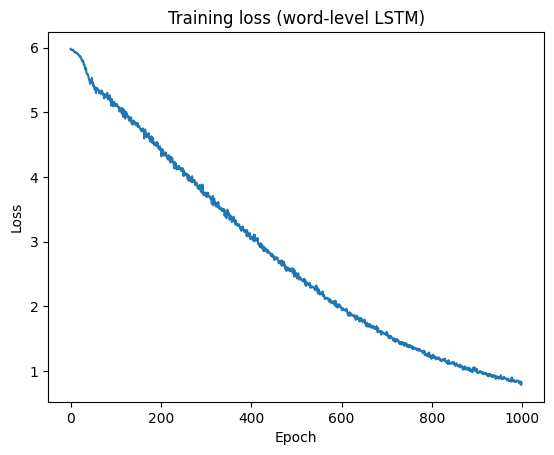

In [15]:

# --- 4. Plot loss history ---
import matplotlib.pyplot as plt
plt.plot(loss_hist)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training loss (word-level LSTM)")
plt.show()

In [16]:


# --- 5. Generate text from model ---
def generate(start_words, length=50):
    model.eval()
    words_in = start_words.lower().split()
    state = None
    generated = words_in.copy()

    for _ in range(length):
        # prepare input
        idxs = [word2idx.get(w, None) for w in words_in]
        idxs = [i for i in idxs if i is not None]
        if not idxs:
            break

        input_seq = torch.tensor([idxs], dtype=torch.long)
        logits, state = model(input_seq, state)
        probs = torch.softmax(logits[0, -1], dim=0).detach().numpy()
        next_idx = np.random.choice(len(probs), p=probs)
        next_word = idx2word.get(next_idx, "<unk>")
        generated.append(next_word)

        words_in = [next_word]

    return " ".join(generated)

print(generate(start_words="once upon a time", length=100))


once upon a time you just not cheerfully out satisfaction and to secure you do not very for your out whole of is better, say anything is for your out, work. they you will the money land, how are you would now self and, still more necessary unequivocal to you; than april in the very coles are exemplified and all for the let herein his herein of the letter to his father. washington, the [written on who corner. the money the civil promptness are bears in very need again. the man, and corner was war pardoned on the following indorsed on the back after
